In [23]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

from datasets import load_dataset
from pathlib import Path

import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from transformers import TrainingArguments

from peft import LoraConfig

from trl import SFTTrainer, DataCollatorForCompletionOnlyLM
from langchain.prompts import PromptTemplate

from IPython.display import Markdown, display

In [17]:
data_dir = Path("../data")
train_path = data_dir / "train.csv"

df = load_dataset("csv", data_files=train_path.as_posix())
print(df)

DatasetDict({
    train: Dataset({
        features: ['id', 'prompt', 'A', 'B', 'C', 'D', 'E', 'answer'],
        num_rows: 200
    })
})


In [35]:
template = '''
    You are the most genius human in the world. You know everything especially about science. Now, I will provide you a question with 5 options. Please choose the correct answer. The response you provide must be one among [A, B, C, D, E].
    
    Question:
    {prompt}\n
    
    Options:
    A) {a}\n
    B) {b}\n
    C) {c}\n
    D) {d}\n
    E) {e}\n
    
    Answer: {answer}
    '''
    
prompt = PromptTemplate(template=template, input_variables=['prompt', 'a', 'b', 'c', 'd', 'e', 'answer'])


In [36]:
sample = df['train'][0]
display(Markdown(prompt.format(prompt=sample['prompt'], 
                               a=sample['A'], 
                               b=sample['B'], 
                               c=sample['C'], 
                               d=sample['D'], 
                               e=sample['E'], 
                               answer=sample['answer'])))


    You are the most genius human in the world. You know everything especially about science. Now, I will provide you a question with 5 options. Please choose the correct answer. The response you provide must be one among [A, B, C, D, E].
    
    Question:
    Which of the following statements accurately describes the impact of Modified Newtonian Dynamics (MOND) on the observed "missing baryonic mass" discrepancy in galaxy clusters?

    
    Options:
    A) MOND is a theory that reduces the observed missing baryonic mass in galaxy clusters by postulating the existence of a new form of matter called "fuzzy dark matter."

    B) MOND is a theory that increases the discrepancy between the observed missing baryonic mass in galaxy clusters and the measured velocity dispersions from a factor of around 10 to a factor of about 20.

    C) MOND is a theory that explains the missing baryonic mass in galaxy clusters that was previously considered dark matter by demonstrating that the mass is in the form of neutrinos and axions.

    D) MOND is a theory that reduces the discrepancy between the observed missing baryonic mass in galaxy clusters and the measured velocity dispersions from a factor of around 10 to a factor of about 2.

    E) MOND is a theory that eliminates the observed missing baryonic mass in galaxy clusters by imposing a new mathematical formulation of gravity that does not require the existence of dark matter.

    
    Answer: D
    

In [38]:
def format_text(row):
    text = prompt.format(prompt=row['prompt'],
                         a=row['A'],
                         b=row['B'],
                         c=row['C'],
                         d=row['D'],
                         e=row['E'],
                         answer=row['answer'],)
    return {"text": text}          

In [39]:
df = df.map(format_text)
df

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'prompt', 'A', 'B', 'C', 'D', 'E', 'answer', 'text'],
        num_rows: 200
    })
})

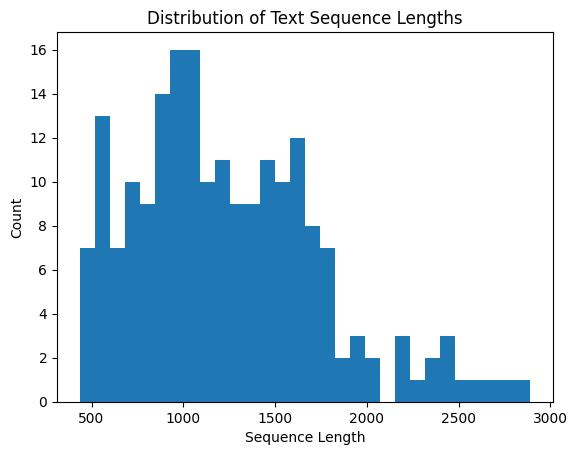

In [40]:
# select only indices shorter than 2048
def plot_sequence_lengths(data, split='train', max_length=2048):
    sequence_lengths = []
    keep_indices = []

    # Loop over the dataset and get the lengths of text sequences
    for i, example in enumerate(data[split]):
        sequence_lengths.append(len(example['text']))
        if sequence_lengths[i] < max_length:
            keep_indices.append(i)

    # Plot the histogram
    plt.hist(sequence_lengths, bins=30)
    plt.xlabel('Sequence Length')
    plt.ylabel('Count')
    plt.title('Distribution of Text Sequence Lengths')
    plt.show()

    return keep_indices
keep_indices_train = plot_sequence_lengths(df)

In [42]:
df['train'] = df['train'].select(keep_indices_train)

IndexError: Index 199 out of range for dataset of size 186.

In [43]:
df

DatasetDict({
    train: Dataset({
        features: ['id', 'prompt', 'A', 'B', 'C', 'D', 'E', 'answer', 'text'],
        num_rows: 186
    })
})

# Load LLM

In [44]:
model_id = "tiiuae/falcon-7b"
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token

c:\Users\warm\.conda\envs\llm_science39\lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\warm\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [45]:
qlora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    target_modules=["query_key_value", "dense", "dense_h_to_4h", "dense_4h_to_h"],
    task_type="CAUSAL_LM"
)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

In [48]:
base_model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    trust_remote_code=True,
    revision="2f5c3cd4eace6be6c0f12981f377fb35e5bf6ee5" # Using this version because running the new version gives error 
)

RuntimeError: No GPU found. A GPU is needed for quantization.

In [49]:
print(torch.cuda.is_available())


False


In [5]:


# quantization configuration for NF4 (4 bits)about:blank#blocked
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type='nf4',
    bnb_4bit_compute_dtype=torch.bfloat16
)

try:
    model = AutoModelForCausalLM.from_pretrained(
        llm,
        device_map="cuda:0",
        quantization_config=quantization_config,
        max_memory="8GB",
        trust_remote_code=True,
    ).eval()

    model.generation_config = GenerationConfig.from_pretrained(llm, trust_remote_code=True)
except Exception as e:
    raise Exception("Failed to load the pretrained model. Error: " + str(e))

c:\Users\warm\.conda\envs\llm_science39\lib\site-packages\bitsandbytes\cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


'NoneType' object has no attribute 'cadam32bit_grad_fp32'


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Exception: Failed to load the pretrained model. Error: Torch not compiled with CUDA enabled